<a href="https://colab.research.google.com/github/Shaheer04/Pakistani-Food-Classifier/blob/main/PreTrainedFoodModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn



torch.__version__

'2.5.1+cu121'

In [2]:
import requests
import zipfile
from pathlib import Path # Importing the Path class from pathlib
data_path = Path("data")

if data_path.is_dir():
  print(f"{data_path} directory already exists")
else:
  print(f"creating {data_path} directory")
  data_path.mkdir(parents=True, exist_ok=True)

with open(data_path/ "Food-dataset.zip", "wb") as f:
  request = requests.get("https://github.com/Shaheer04/Pakistani-Food-Classification/raw/refs/heads/main/data/Food-dataset.zip")
  print("downloading dataset ....")
  f.write(request.content)

with zipfile.ZipFile(data_path / "Food-dataset.zip", "r") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(data_path)


creating data directory
downloading dataset ....
Unzipping data...


In [3]:
from torchvision import datasets
# Load full dataset
full_dataset = datasets.ImageFolder(
    root='/content/data/Fooddataset',
    transform=None  # No transform applied here yet
)


In [4]:
full_dataset.classes

['bbq', 'biryani', 'french_fries']

In [5]:
full_dataset.class_to_idx

{'bbq': 0, 'biryani': 1, 'french_fries': 2}

In [6]:
from torchvision import transforms
# Custom preprocessing pipeline
train_transform = transforms.Compose([
    transforms.Resize(256),                  # Resize to match pretrained model input
    transforms.RandomCrop(224),              # Standard size for ResNet/EfficientNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5773, 0.4623, 0.3385], std=[0.2559, 0.2411, 0.2455]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5773, 0.4623, 0.3385], std=[0.2559, 0.2411, 0.2455]),
])

In [7]:
from torch.utils.data import DataLoader, Subset, Dataset
# Custom dataset wrapper to apply transforms

class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

In [8]:
from torch.utils.data import random_split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_size, test_size

# Get the indices for the training and testing sets
train_indices = list(range(train_size))  # Create a list of indices for training
test_indices = list(range(train_size, len(full_dataset)))  # Create a list of indices for testing


In [9]:
# Create subsets with transforms
train_subset = TransformDataset(
    Subset(full_dataset, train_indices),
    transform=train_transform
)

test_subset = TransformDataset(
    Subset(full_dataset, test_indices),
    transform=test_transform
)

class_names = full_dataset.classes

In [10]:
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_subset)}")
print(f"Testing images: {len(test_subset)}")

Total images: 300
Training images: 240
Testing images: 60


In [11]:
# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7cae4f8e4690>,
 <torch.utils.data.dataloader.DataLoader at 0x7cae4fa9fb90>)

In [12]:
import matplotlib.pyplot as plt
import random
# 1. Create a function to take in a dataset
from typing import List
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


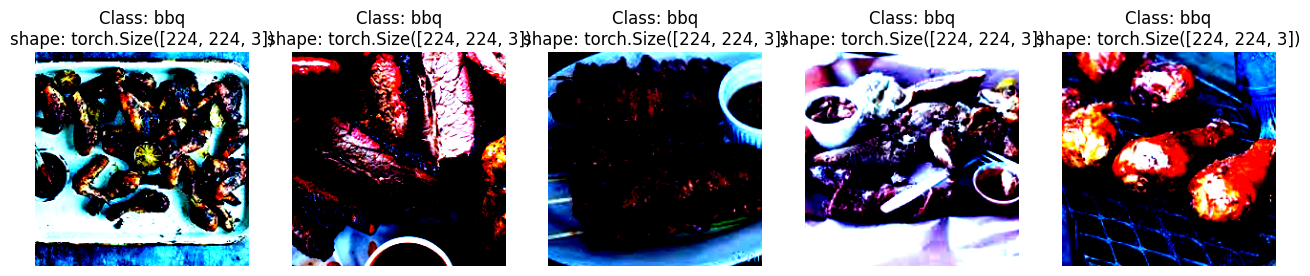

In [13]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_subset,
                      n=5,
                      classes=class_names,
                      seed=None)

In [14]:
import torch
import torchvision.models as models

# Load pretrained model
model = models.resnet18(pretrained=True)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Replace final layer (adjust num_classes to your case)
num_classes = 3  # french_fries, bbq, biryani
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


In [15]:
import torch.optim as optim

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer (only train the classifier first)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

In [16]:
num_epochs = 10
best_val_acc = 0.0
metrics = {"train_loss" : [],
           "train_acc": [],
           "test_loss" : [],
           "val_acc": [],
           }

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate metrics
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(test_loader.dataset)
    train_acc = train_correct / train_total
    val_acc = correct / total


    # Update scheduler
    scheduler.step(val_loss)

    # Saving Metrics for Plotting
    metrics["train_loss"].append(train_loss)
    metrics["train_acc"].append(train_acc)
    metrics["test_loss"].append(val_loss)
    metrics["val_acc"].append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.9949 | Val Loss: 1.0948 | Val Acc: 0.4500
Epoch 2/10
Train Loss: 0.7562 | Val Loss: 1.1510 | Val Acc: 0.3667
Epoch 3/10
Train Loss: 0.5853 | Val Loss: 0.9403 | Val Acc: 0.6333
Epoch 4/10
Train Loss: 0.4468 | Val Loss: 0.5264 | Val Acc: 0.8333
Epoch 5/10
Train Loss: 0.4012 | Val Loss: 0.4954 | Val Acc: 0.8167
Epoch 6/10
Train Loss: 0.3403 | Val Loss: 0.5476 | Val Acc: 0.7833
Epoch 7/10
Train Loss: 0.2878 | Val Loss: 0.3944 | Val Acc: 0.8500
Epoch 8/10
Train Loss: 0.2512 | Val Loss: 0.3351 | Val Acc: 0.8333
Epoch 9/10
Train Loss: 0.2590 | Val Loss: 0.4374 | Val Acc: 0.8333
Epoch 10/10
Train Loss: 0.2376 | Val Loss: 0.2856 | Val Acc: 0.8667


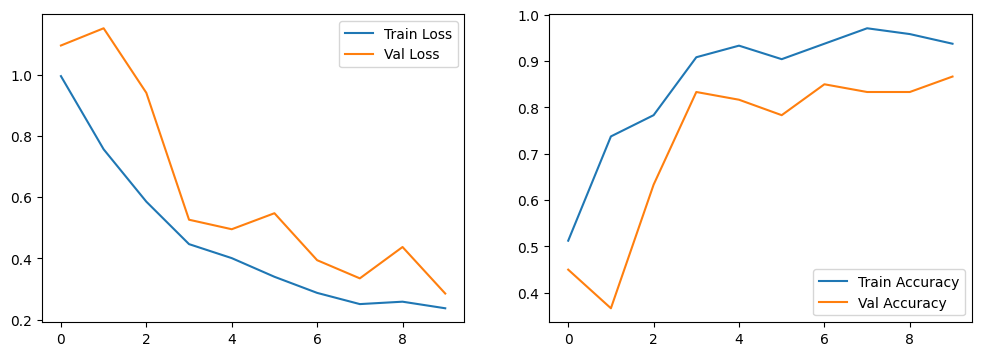

In [17]:
import matplotlib.pyplot as plt

# Plot loss and accuracy curves (after training)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics["train_loss"], label='Train Loss')
plt.plot(metrics["test_loss"], label='Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics["train_acc"], label='Train Accuracy')
plt.plot(metrics["val_acc"], label='Val Accuracy')
plt.legend()
plt.show()

In [18]:
import requests

custom_image_path = data_path / "biryani.jpg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/Shaheer04/Pakistani-Food-Classification/blob/main/test_imgs/biryani_img.jpg?raw=true")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")


In [19]:
import torchvision
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.7765, 0.7686, 0.7608,  ..., 0.5725, 0.5961, 0.6118],
         [0.7922, 0.7882, 0.7882,  ..., 0.5882, 0.6039, 0.6118],
         [0.7882, 0.7843, 0.7843,  ..., 0.6157, 0.6235, 0.6235],
         ...,
         [0.7059, 0.6941, 0.6863,  ..., 0.0863, 0.0784, 0.0824],
         [0.6902, 0.6863, 0.6863,  ..., 0.2392, 0.2392, 0.2431],
         [0.6784, 0.6745, 0.6824,  ..., 0.2745, 0.2902, 0.2863]],

        [[0.8902, 0.8824, 0.8784,  ..., 0.4431, 0.4745, 0.4902],
         [0.9059, 0.9020, 0.9059,  ..., 0.4588, 0.4745, 0.4902],
         [0.8941, 0.8902, 0.8941,  ..., 0.4902, 0.4980, 0.4980],
         ...,
         [0.4980, 0.4863, 0.4784,  ..., 0.0000, 0.0000, 0.0000],
         [0.4824, 0.4784, 0.4784,  ..., 0.1255, 0.1137, 0.1216],
         [0.4706, 0.4667, 0.4745,  ..., 0.1490, 0.1529, 0.1490]],

        [[0.9608, 0.9451, 0.9216,  ..., 0.0235, 0.0510, 0.0667],
         [0.9765, 0.9647, 0.9490,  ..., 0.0392, 0.0549, 0.0667],
         [0.9765, 0.9647, 0.9490,  ..., 0.0627, 0.0706, 0.

In [34]:
# Create transform pipeline to resize image
from torchvision import transforms
from PIL import Image

custom_image_transform = transforms.Compose([
    transforms.Resize(256),                  # Resize to match pretrained model input
    transforms.RandomCrop(224),              # Standard size for ResNet/EfficientNet
    transforms.Normalize(mean=[0.5773, 0.4623, 0.3385], std=[0.2559, 0.2411, 0.2455]),
])

# Open the image using PIL
custom_image_pil = Image.open(custom_image_path).convert('RGB')  # Ensure RGB format

# Transfrom target image
#custom_image_transformed = custom_image_transform(custom_image_pil)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 720, 1280])
Transformed shape: torch.Size([3, 224, 224])


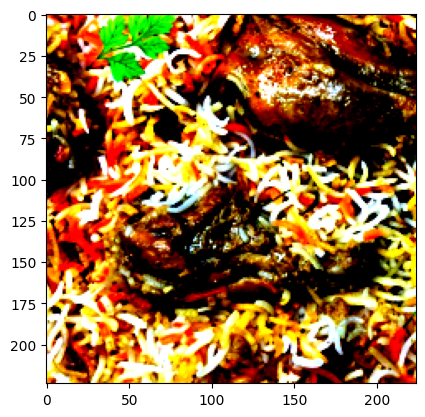

In [21]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [22]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [23]:
model.eval()
with torch.inference_mode():
  custom_image_pred = model(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.1203,  1.3224, -1.3239]])

In [24]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.2192, 0.7291, 0.0517]])

In [25]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([1])

In [26]:
class_names[custom_image_pred_label]

'biryani'

In [35]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary

  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert predction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

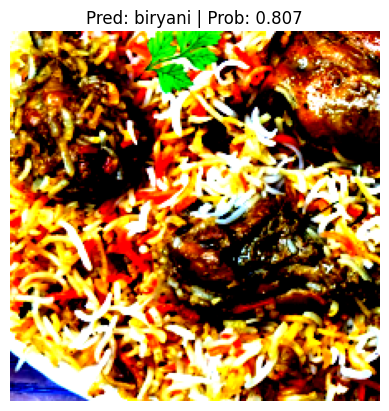

In [36]:
# Pred on our custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [37]:
class_names

['bbq', 'biryani', 'french_fries']